In [343]:
import pandas as pd
import numpy as np

name = '170315prn10_filt.csv'

datosPath = '/home/javier/Escritorio/Teledeteccion'

sat = pd.read_csv(datosPath + name, delimiter = ';')

fecha = name[:3]
for i in range(len(name)):
    if name[i] == '_':
        prn = name[9:i]
print(fecha)
print(prn)
    

sat.columns

angulos = sat['ang'].values
intensidad = sat['intens'].values

Angulos = (90-angulos)[::-1]
Intensidad = intensidad[::-1] # intensidad ordenada por angulo thita
elevMin = np.min(Angulos)
elevMax = np.max(Angulos)
I_min = np.min(Intensidad)
I_max = np.max(Intensidad)
I_mean = np.mean(Intensidad)
delta_max = np.std(Intensidad)

# normalizo la señal para que oscile entre [-1,1]
I = (Intensidad-I_mean)/delta_max
std_I =np.std(I)

N_thitas = len(angulos) # número de datos medidos ---> nro de titas a usar en la simulacion

# hago una interpolación para pasar de escalones a ángulos continuos

####
print("nro de thitas", N_thitas)
print('elevMin =', elevMin)
print('elevMax =', elevMax)
print("I_min = ", I_min)
print("I_max = ", I_max)
print("I_mean = ", I_mean)
print("I_std = ", delta_max)

170
10
nro de thitas 452
elevMin = 67.02
elevMax = 82.99
I_min =  35.75
I_max =  47.9
I_mean =  42.06028761061947
I_std =  2.76948098337579


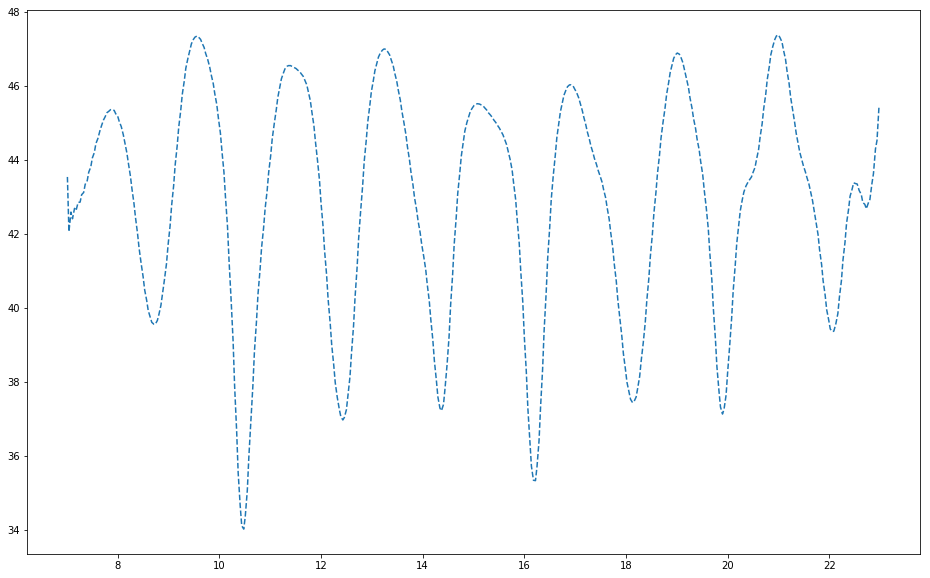

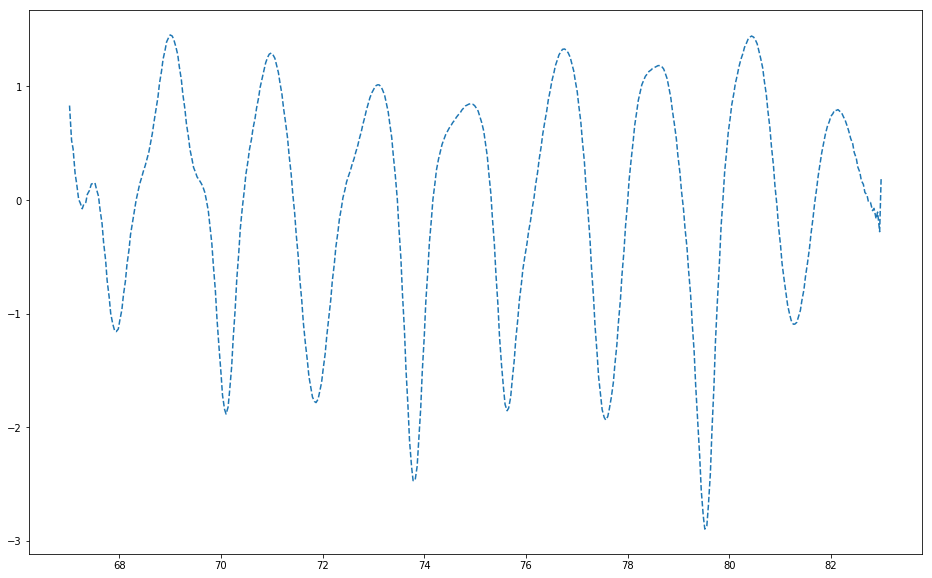

In [263]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(16,10))
ax.errorbar(angulos,intensidad,yerr=0.0, fmt='--', errorevery=1, ecolor='r')
plt.show()
fig, ax = plt.subplots(figsize=(16,10))
ax.errorbar(Angulos,I,yerr=0.0, fmt='--', errorevery=1, ecolor='r')
plt.show()



Genero una familia de curvas teóricas

Escribo la salida de la simulación como dos array distintos

In [328]:
## cargo corridas guardadas como npy
#out_1sup = np.load('Y_1sup_denso.npy')
out_1sup = np.load('Z_1sup.npy')
print(np.shape(out_1sup))
#out_1sup = np.reshape(out_1sup,(452,12,3,5)) #Esto lo hago por las dudas

#out_2sup = np.load('Y_2sup_denso.npy')
out_2sup = np.load('Z_2sup.npy')
print(np.shape(out_2sup))
#out_2sup = np.reshape(out_2sup,(452, 12, 12, 3, 3, 4, 5))

(452, 10, 3, 5)
(452, 10, 10, 3, 3, 5, 5)


In [186]:
#CORRER SOLO SI HAY QUE CORTAR DATOS

out_1sup = out_1sup[(452-N_thitas):,:,:,:] #[:-(452-N_thitas),:,:,:]#[(452-N_thitas):,:,:,:]
print(np.shape(out_1sup))
out_2sup = out_2sup[(452-N_thitas):,:,:,:,:,:]
print(np.shape(out_2sup))


(279, 12, 3, 5)
(279, 12, 12, 3, 3, 4, 5)


In [256]:
#epsilons grande

n_thi = N_thitas
thiRange = np.linspace(elevMin*np.pi/180,elevMax*np.pi/180,N_thitas)

n_ep1, n_ep2 = 12, 12
n_s1, n_s2 = 3, 3
n_ZA = 5

ep1Range = np.linspace(14,25, n_ep1)
ep2Range = np.linspace(20,35, n_ep2)

s1Range = np.linspace(0.00, 0.02, n_s1)
s2Range = np.linspace(0.00, 0.02, n_s2)

dRange = np.array([0.01,0.03,0.08,0.09]) 
n_d = len(dRange)

#ZARange = np.array([2.1,2.2,2.3,2.35,2.4]) 
ZARange = np. linspace(2,2.6,n_ZA)


In [344]:
#epsilon chico

n_ep1, n_ep2 = 10, 10
n_D = 5
n_ZA = 5

thiRange = np.linspace(elevMin*np.pi/180,elevMax*np.pi/180,N_thitas)


ep1Range = np.linspace(4,15, n_ep1)
ep2Range = np.linspace(12,25, n_ep2)


s1Range = np.array([0.0,0.005,0.01]) 
n_s1 = len(s1Range)
s2Range = np.array([0.0,0.005,0.01]) 
n_s2 = len(s2Range)
dRange = np.array([0.01,0.03,0.05,0.08,0.09]) 
n_d = len(dRange)
ZARange = np. linspace(2.0,2.6,n_ZA)


In [346]:
#Algoritmo para minimizar la señal medida vs la señal simulada

## una interface ##
cota_1sup =1.55 # error RMS que tolero



salidas_1sup = np.zeros((n_ep1,n_s2,n_ZA))
sal_OK_1sup= [] # genero una lista vacia que iré llenando con (ep2,s2,ZA) a medida que la salida verifique la condicion que le doy
Int_OK_1sup = []

for i1 in range(len(ep1Range)):
    for i2 in range(len(s2Range)):
        for i3 in range(len(ZARange)):
            norm_teo = np.mean(out_1sup[:,i1,i2,i3])
            # error RMS
            res = np.sqrt(np.sum((10*np.log10(out_1sup[:,i1,i2,i3]/norm_teo)-I)**2)/len(I))
            # error MS
            #res = np.sum(np.abs(10*np.log10(out_1sup[:,i1,i2,i3]/norm_teo)-I))/len(I)
            salidas_1sup[i1,i2,i3] = res # error RMS entre la señal y cada una de las curvas teóricas
            if res < cota_1sup:
                sal_OK_1sup.append((salidas_1sup[i1,i2,i3],ep1Range[i1],s2Range[i2],ZARange[i3])) # guardo las curvas que tienen un e_RMS menor a una cota
                Int_OK_1sup.append(10*np.log10(out_1sup[:,i1,i2,i3]/norm_teo))

                                
final_1sup = np.asarray(sal_OK_1sup)
N_sols_1sup = np.size(final_1sup,0)

print("nro de soluciones admitidas (una interface) = ", N_sols_1sup)

Int_final_1sup = np.asarray(Int_OK_1sup)


nro de soluciones admitidas (una interface) =  72


In [350]:
## dos interfaces ##

cota_2sup = 1.24 # error RMS que tolero



dim_tot = (n_ep1,n_ep2,n_s1,n_s2,n_d,n_ZA)
salidas_2sup = np.zeros(dim_tot)
sal_OK_2sup = [] # genero una lista vacia que iré llenando con (ep1,eo2,s1,s2,d,ZA) a medida que la salida verifique la condicion que le doy
Int_OK_2sup = []

for i1 in range(len(ep1Range)):
    for i2 in range(len(ep2Range)):
        for i3 in range(len(s1Range)):
            for i4 in range(len(s2Range)):
                for i5 in range(len(dRange)):
                    for i6 in range(len(ZARange)):
                        norm_teo = np.mean(out_2sup[:,i1,i2,i3,i4,i5,i6])
                        # error RMS
                        res = np.sqrt(np.sum((10*np.log10(out_2sup[:,i1,i2,i3,i4,i5,i6]/norm_teo)-I)**2)/len(I))
                        salidas_2sup[i1,i2,i3,i4,i5,i6] = res # error RMS entre la señal y cada una de las curvas teóricas
                        if res < cota_2sup:
                            sal_OK_2sup.append((salidas_2sup[i1,i2,i3,i4,i5,i6],ep1Range[i1],ep2Range[i2],s1Range[i3],s2Range[i4],dRange[i5],ZARange[i6])) # guardo las curvas que tienen un e_RMS menor a una cota
                            Int_OK_2sup.append(10*np.log10(out_2sup[:,i1,i2,i3,i4,i5,i6]/norm_teo))
final_2sup = np.asarray(sal_OK_2sup)
N_sols_2sup = np.size(final_2sup,0)

print("nro de soluciones admitidas (dos interfaces) = ", N_sols_2sup)

Int_final_2sup = np.asarray(Int_OK_2sup)

nro de soluciones admitidas (dos interfaces) =  74


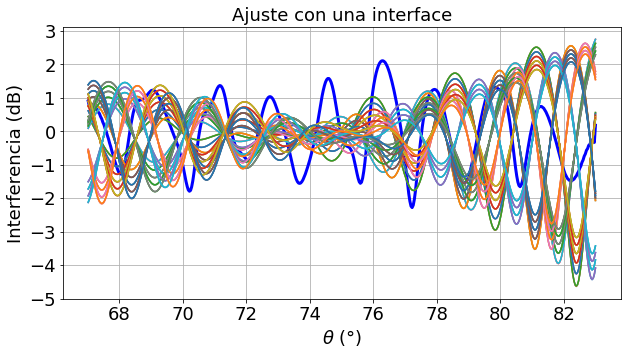

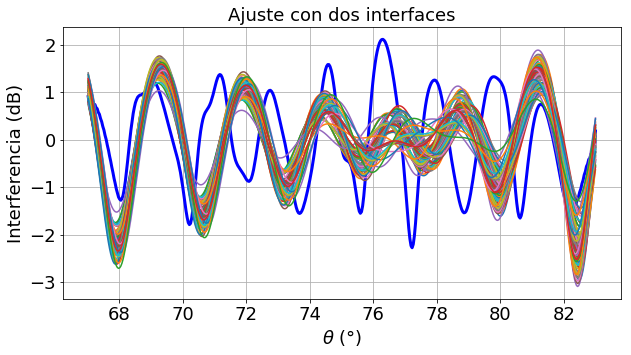

In [355]:
import matplotlib
#matplotlib.rcParams['text.usetex'] = True
from matplotlib import pyplot as plt
%matplotlib inline
from time import strftime

hora = strftime("%H,%M,%S")
Path_figs = 'C:/Users/eugen/OneDrive/Documentos/labo 6_7/mediciones/filtradas utiles/imagenes/'

# soluciones admitidas una iterface #
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(thiRange*180/np.pi,I,'b', linewidth= 3)
#ax.errorbar(thiRange*180/np.pi,I, fmt='--', linewidth= 3)
for l in range (N_sols_1sup):
    plt.plot(thiRange*180/np.pi,Int_final_1sup[l,:])
plt.grid()
plt.ylabel('Interferencia (dB)', fontsize = 18)
plt.xlabel(r'$\theta$ (°)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Ajuste con una interface', fontsize = 18)
plt.savefig( Path_figs + prn + fecha+ ' '+hora+'_ajuste_1capa.png')
plt.show()

# soluciones admitidas dos interfaces #
fig, ax = plt.subplots(figsize=(10,5))
#plt.plot(thiRange*180/np.pi,I)
plt.plot(thiRange*180/np.pi,I,'b', linewidth= 3)
for l in range (N_sols_2sup):
    plt.plot(thiRange*180/np.pi,Int_final_2sup[l,:])
ax.grid()
plt.xlabel(r'$\theta$ (°)', fontsize = 18)
plt.ylabel('Interferencia (dB)', fontsize = 18)
plt.legend(loc='best',fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('Ajuste con dos interfaces', fontsize = 18)
plt.savefig( Path_figs + prn + fecha+' '+hora+ '_ajuste_2capas.png')
plt.show()

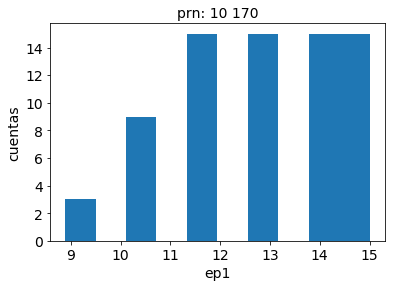

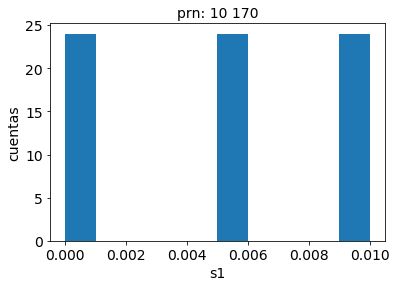

=========== RESULTADOS MODELO DE UNA CAPA ===========
ep1 =13.0±2.0
s1 =0.005±0.004
ZA =2.281±0.209


In [356]:
## RESULTADOS CON UNA INTERFACE ##
# final_1sup = [e_RMS, ep1, s1, ZA]

Path_figs = 'C:/Users/eugen/OneDrive/Documentos/labo 6_7/mediciones/filtradas utiles/imagenes/'

# histograma para los valores que me interesan y que son solucion

##---- estadística para ep1 ------------##
plt.hist(final_1sup[:,1], bins=10)
plt.xlabel('ep1', fontsize = 14)
plt.ylabel('cuentas', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('prn: '+prn+' '+fecha , fontsize = 14)
plt.savefig(Path_figs + prn + ' '+fecha+ '1capa'+'_ep.png')
plt.show()


##---- estadística para s1 ------------##
plt.hist(final_1sup[:,2], bins=10)
plt.xlabel('s1', fontsize = 14)
plt.ylabel('cuentas', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('prn: '+prn+' '+fecha , fontsize = 14)
plt.savefig(Path_figs + prn + ' '+fecha+ '1capa'+'_s.png')

plt.show()


ep_medio = np.mean(final_1sup[:,1])
ep_error = np.std(final_1sup[:,1])

s_medio = np.mean(final_1sup[:,2])
s_error = np.std(final_1sup[:,2])

ZA0_medio = np.mean(final_1sup[:,3])
ZA0_error = np.std(final_1sup[:,3])

##---- estadística de todos los parametros  -----##
print('=========== RESULTADOS MODELO DE UNA CAPA ===========')
print('ep1 =' + str(round(ep_medio,0)) + u'\u00B1' + str(round(ep_error,0)))
print('s1 =' + str(round(s_medio,3)) + u'\u00B1' + str(round(s_error,3)))
print('ZA =' + str(round(ZA0_medio,3)) + u'\u00B1' + str(round(ZA0_error,3)))
print('=====================================================')

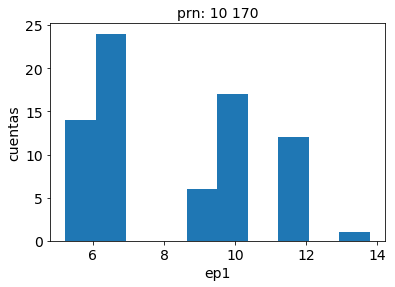

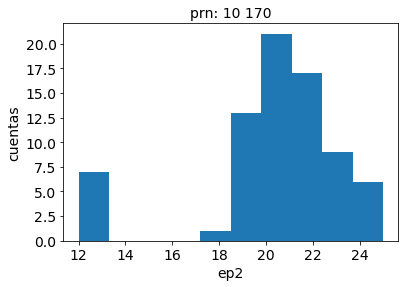

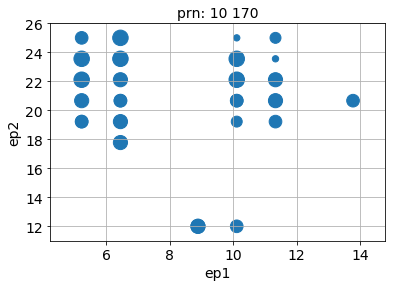

=========== RESULTADOS MODELO DE DOS CAPAS ===========
ep1 = 8.0±2.0
ep2 = 21.0±3.0
s1 = 0.007±0.004
s2 = 0.008±0.003
D = 0.062±0.026
ZA = 2.15±0.0


In [357]:
## RESULTADOS CON DOS INTERFACES ##
# final_2sup = [e_RMS, ep1, ep2, s1,s2, d, ZA]

Path_figs = 'C:/Users/eugen/OneDrive/Documentos/labo 6_7/mediciones/filtradas utiles/imagenes/'

# histograma para los valores que me interesan y que son solucion

##---- histograma para ep1 ------------##
#nro_bins_2sup = int(round(np.sqrt(N_sols_2sup)))
#plt.hist(final_2sup[:,0], bins=nro_bins_2sup)
#plt.xlabel('error RMS', fontsize = 14)
#plt.ylabel('cuentas', fontsize = 14)
#plt.xticks(fontsize = 14)
#plt.yticks(fontsize = 14)
#plt.title('prn: '+prn+' '+fecha , fontsize = 14)
#plt.show()


##---- histograma para ep1 ------------##
plt.hist(final_2sup[:,1], bins=n_ep1)
plt.xlabel('ep1', fontsize = 14)
plt.ylabel('cuentas', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('prn: '+prn+' '+fecha , fontsize = 14)
plt.savefig(Path_figs + prn + ' '+fecha+ '2capa'+'_ep1.png')
plt.show()

##---- histograma para ep2 ------------##
plt.hist(final_2sup[:,2], bins=n_ep2)
plt.xlabel('ep2',fontsize = 14)
plt.ylabel('cuentas', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('prn: '+prn+' '+fecha , fontsize = 14)
plt.savefig(Path_figs + prn + ' '+fecha+'2capa'+ '_ep2.png')
plt.show()

##---- correlacion ep1 vs ep2 ------------##

# agrupo de a pares (ep1,ep2) que fueron solución
combinaciones = zip(final_2sup[:,1].flatten(),final_2sup[:,2].flatten()) 

from itertools import groupby
# cuento la cantidad de repeticion de cada par (ep1,ep2)
cantidad_ep1_ep2 = [40*len(list(group)) for key, group in groupby(combinaciones)]


plt.scatter(final_2sup[:,1].flatten(),final_2sup[:,2].flatten(),s = cantidad_ep1_ep2)
plt.xlabel('ep1', fontsize = 14)
plt.ylabel('ep2', fontsize = 14)
plt.xlim([min(final_2sup[:,1].flatten())-1,max(final_2sup[:,1].flatten())+1])
plt.ylim([min(final_2sup[:,2].flatten())-1,max(final_2sup[:,2].flatten())+1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('prn: '+prn+' '+fecha , fontsize = 14)
plt.grid()
plt.savefig(Path_figs + prn + ' '+fecha+'2capa'+'_ep1_ep2.png')
plt.show()

##---- estadística de los otros parámetros -----##
from scipy import stats

ep1_medio = np.mean(final_2sup[:,1])
ep1_std = np.std(final_2sup[:,1])
ep1_moda = stats.mode(final_2sup[:,1])[0]
ep1_mediana = np.median(final_2sup[:,1])

ep2_medio = np.mean(final_2sup[:,2])
ep2_std = np.std(final_2sup[:,2])
ep2_moda = stats.mode(final_2sup[:,2])[0]
ep2_mediana = np.median(final_2sup[:,2])

s1_medio = np.mean(final_2sup[:,3])
s1_std = np.std(final_2sup[:,3])
s1_moda = stats.mode(final_2sup[:,3])[0]
s1_mediana = np.median(final_2sup[:,3])

s2_medio = np.mean(final_2sup[:,4])
s2_std = np.std(final_2sup[:,4])
s2_moda = stats.mode(final_2sup[:,4])[0]
s2_mediana = np.median(final_2sup[:,4])

D_medio = np.mean(final_2sup[:,5])
D_std = np.std(final_2sup[:,5])
D_moda = stats.mode(final_2sup[:,5])[0]
D_mediana = np.median(final_2sup[:,5])

ZA_medio = np.mean(final_2sup[:,6])
ZA_std = np.std(final_2sup[:,6])
ZA_moda = stats.mode(final_2sup[:,6])[0]
ZA_mediana = np.median(final_2sup[:,6])


##---- estadística de todos los parametros  -----##
print('=========== RESULTADOS MODELO DE DOS CAPAS ===========')
print('ep1 = ' + str(round(ep1_medio,0)) + u'\u00B1'  + str(round(ep1_std,0)))
print('ep2 = ' + str(round(ep2_medio,0)) + u'\u00B1'  + str(round(ep2_std,0)))
print('s1 = '  + str(round(s1_medio,3))  + u'\u00B1'  + str(round(s1_std,3)))
print('s2 = '  + str(round(s2_medio,3))  + u'\u00B1'  + str(round(s2_std,3)))
print('D = '   + str(round(D_medio,3))   + u'\u00B1'  + str(round(D_std,3)))
print('ZA = '  + str(round(ZA_medio,2))  + u'\u00B1'  + str(round(ZA_std,2)))
print('=====================================================')

In [336]:
# Ajusto el patrón de interferencia usando curve_fit: busca los mejores parámetros para la curva

import numpy as np
from scipy.optimize import curve_fit
import pylab
import matplotlib
from matplotlib import pyplot as plt

k0 = 2*np.pi/0.19
n = N_thitas
x = thiRange
x0 = 78
sigma = np.ones(n)*0.05
sigma[np.abs(x-x0+1)<1] = 0.3
noise = np.random.randn(n) * sigma

# medicion a ajustar
y = I


# curva teorica para hacer el ajuste
def F(x,ep1,ep2,s1,s2,d,ZA):
    return 1 + 2*np.real(a0VV(k0,x,ep1,ep2,d)*exp(1j*2*k0*cos(x)*ZA))+abs(a0VV(k0,x,ep1,ep2,d))**2\
            + abs(a1VVF1(k0,x,0,x,0,ep1,ep2,d))**2*s1**2 \
            + abs(a1VVF2(k0,x,0,x,0,ep1,ep2,d))**2*s2**2

def F_fit(x,ep1,ep2,s1,s2,d,ZA):
    return 10*np.log10(F(x,ep1,ep2,s1,s2,d,ZA)/np.mean(F(x,ep1,ep2,s1,s2,d,ZA)))


# defino el error
def rms(y, yfit):
    return np.sum(np.abs(y-yfit))/len(y)

# Unweighted fit
p0 = 16, 25, 0.01, 0.01, 0.06, 2.44  # parámetros inciales para el ajuste
popt, pcov = curve_fit(F_fit, x, y, p0, maxfev = 1600, bounds = (0,[25,35,0.02,0.02,0.1,2.5]))
yfit = F_fit(x, *popt)
print('Unweighted fit parameters:', popt)
print('Covariance matrix:'); print(pcov)
print('rms error in fit:', rms(y, yfit))
print()

# Weighted fit
popt2, pcov2 = curve_fit(F_fit, x, y, p0, sigma=sigma, absolute_sigma=True,maxfev=1500, bounds = (0,[25,35,0.02,0.02,0.1,2.5]))
yfit2 = F_fit(x, *popt2)
print('Weighted fit parameters:', popt2)
print('Covariance matrix:'); print(pcov2)
# print('rms error in fit:', rms(yexact, yfit2))

fig, ax = plt.subplots(figsize=(16,10))
plt.plot(x*180/np.pi, y, 'o', label='Medicion')
plt.plot(x*180/np.pi, yfit, label='Ajuste no pesado')
plt.plot(x*180/np.pi, yfit2, label='Weighted fit')
plt.legend(loc='upper right')
plt.show()

NameError: name 'a0VV' is not defined